In [207]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer, auc

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm
from sklearn.utils import resample


# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots

RANDOM = 0
figure_path = "../figures/NCDB_7_features/"

In [208]:

# custom func
def pretty_cm(confmat, filename):

     """
     this creates the matplotlib graph to make the confmat look nicer
     """
     fig, ax = plt.subplots(figsize=(6, 4))
     ax.matshow(confmat, cmap=plt.cm.Reds, alpha=0.3)
     for i in range(confmat.shape[0]):
         for j in range(confmat.shape[1]):
             ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize = 20)
       
     ax.set_xticklabels(['']+['Mets', 'No Mets'])
     ax.set_yticklabels(['']+['Mets', 'No Mets'])
     plt.xlabel('Predicted Label', size = 20)
     plt.ylabel('True Label', fontsize = 20)
     plt.xticks(fontsize = 15)
     plt.yticks (fontsize = 15)
     ax.xaxis.set_label_position('top')
     plt.tight_layout()
     plt.savefig(filename)
     plt.show()

## 1. Prep data

- load data 

In [209]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv") 


### Filter for features of interest
- 7 features (excluding tumor_depth) 

In [210]:
# fix up some features
df['AGE'] = df.AGE.astype('float')
df['no_mets'] = df.metastasis.replace({0:1, 1:0})
df['tumor_site'] = df.tumor_site.astype("category")
# select only features for analysis
df = df[['no_mets', 'AGE', 'tumor_size', 'tumor_site', 'SEX', 
               'tumor_lymphocytes', 'lymph_vasc_invasion', 'immuno_suppressed']]
df = df.dropna(axis = 0)
df.columns

Index(['no_mets', 'AGE', 'tumor_size', 'tumor_site', 'SEX',
       'tumor_lymphocytes', 'lymph_vasc_invasion', 'immuno_suppressed'],
      dtype='object')

### designate features and outcome

In [211]:
outcome = df['no_mets']
features = df.drop(columns = 'no_mets')

### Define preprocessing
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)
- standard scale (zscore) numeric, continuous features

In [212]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size']
cat_features = ['tumor_site']
all_features = features.columns

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first'))])


# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)],
    remainder = 'passthrough')


# generate interaction terms from all features after transforming 
add_interactions = Pipeline(steps=[
    ('interaction_terms', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))])

# put together the column transfrmer and option to add interactions
preproc_basic = Pipeline(steps = [('preproc', preprocessor)])
preproc_interactions = Pipeline(steps = [('preproc', preprocessor),
                                       ('int', add_interactions)])

preproc_X_check = pd.DataFrame(preproc_basic.fit_transform(features))    
preproc_X_check.shape

(1273, 9)

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 5 folds repeated 5x with random sampling

In [295]:
# split into train-test split, 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats =  5,  
                                    random_state = 0)

## Tune lasso models 
- logistic regression for classification
- automated feature selection via L1 regularization  (Lasso)


In [214]:

Lasso_L1 = LogisticRegression( penalty = 'l1',
                                 solver = 'liblinear', 
                                 max_iter = 1000, 
                                 random_state = RANDOM)
Lasso_L1_balanced =  LogisticRegression(class_weight = "balanced",
                                 penalty = 'l1',
                                 solver = 'liblinear', 
                                 max_iter = 1000, 
                                 random_state = RANDOM)


### grid search
 comparisons in grid search
 - with or without interactions in preproc
 - with or without balanced class weights 
 - different levels of regularization (parameter C, inverse of alpha in R)




In [215]:

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
              'average_precision': 'average_precision', 
             'brier_score_loss': 'brier_score_loss'}
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [616]:
classifiers = [Lasso_L1, Lasso_L1_balanced]
classifier_names = ["L1", "L1 bal"]
preproc_options = [preproc_basic, preproc_interactions]
preproc_names = ['Basic', 'Interactions']

i = 0

grid_results = pd.DataFrame()
for classifier in classifiers:
    j = 0
    for preproc_choice in preproc_options:
        pipe =  Pipeline(steps = [('preprocessing', preproc_choice),
                                  ('model', classifier)])
        grid = GridSearchCV(pipe,
                        param_grid = param_grid_C, 
                        return_train_score = True,
                        cv = CV_folds, 
                        scoring = score_list,
                        refit = "precision",
                        n_jobs =  -1)
        grid.fit(X_trainval, y_trainval)
        results = pd.DataFrame(grid.cv_results_)
        results['model'] = classifier_names[i]
        results['preproc'] = preproc_names[j]
        print(classifier_names[i])
        print(preproc_names[j])
        grid_results = pd.concat([grid_results, results], ignore_index = True)
        j = j+1
    i = i+1



L1
Basic
L1
Interactions
L1 bal
Basic
L1 bal
Interactions


In [621]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log10(x))

# clean up dataframe so only have mean scores 
grid_results = grid_results[['model', 'preproc', 'param_model__C', 'log_C',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_average_precision', 'mean_test_average_precision',
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]


In [622]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['model', 'preproc', 'param_model__C', 'log_C'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                         'mean_train_average_precision', 'mean_test_average_precision',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")
grid_results_long.columns

Index(['model', 'preproc', 'param_model__C', 'log_C', 'metric', 'score',
       'dataset'],
      dtype='object')

## Visualize hyperparameter tuning: learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 
- interactions don't help! 
- balancing the class weights does help.

<Figure size 576x720 with 0 Axes>

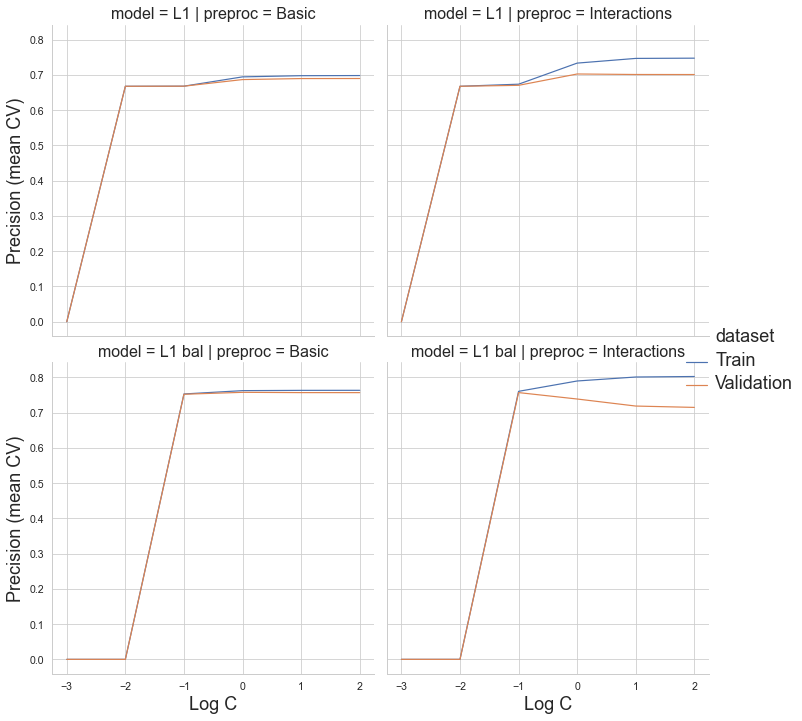

In [623]:
# figure of model comparisons on training  
plt.figure(figsize = (8, 10))
g = sns.relplot(data = grid_results_long[(grid_results_long.metric == "precision")], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  
                kind = "line",  col = "preproc", row = "model")
g.set_xlabels("Log C", size = 18)
g.set_ylabels("Precision (mean CV)", size = 18)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 18)
g.set_titles(size = 16)
#plt.savefig(os.path.join(figure_path, "Grid_CV_learning_curves_precision.png"))

## Find the best model

In [624]:
best_metric = grid_results['mean_test_precision'].max()
match_best = grid_results['mean_test_precision'] == best_metric
best_model = grid_results[match_best]
best_model

,model,preproc,param_model__C,log_C,mean_train_f1,mean_test_f1,mean_train_precision,mean_test_precision,mean_train_recall,mean_test_recall,mean_train_acc,mean_test_acc,mean_train_roc_auc,mean_test_roc_auc,mean_train_average_precision,mean_test_average_precision,mean_train_brier_score_loss,mean_test_brier_score_loss
15,L1 bal,Basic,1.0,0.0,0.731094,0.725263,0.762061,0.757271,0.702667,0.696983,0.654927,0.648212,0.657258,0.631777,0.775176,0.7563,-0.230517,-0.23533


In [222]:

print("Best precision: %0.3f" % best_metric)
print("Best Recall %0.3f" % best_model['mean_test_recall'])

print("Best PR AUC : %0.3f " % best_model['mean_test_average_precision'])
print("Best ROC AUC %0.3f " % best_model['mean_test_roc_auc'])

print("Best F1 score:%0.3f " % best_model['mean_test_f1'])
print("Best C parameter: %.3f" % best_model['param_model__C'])
print("Best model: %s with %s " % (best_model['model'], best_model['preproc']))


Best precision: 0.757
Best PR AUC : 0.756 
Best F1 score:0.725 
Best ROC AUC 0.632 
Best Recall 0.697
Best C parameter: 1.000
Best model: 15    L1 bal
Name: model, dtype: object with 15    Basic
Name: preproc, dtype: object 


### obtain feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.
- preprocessor changes order of variables

In [728]:

# get new feature order frorm preprocessor
preproc_feature_order = pd.DataFrame(modeling.get_feature_names(preprocessor))
preproc_feature_order.columns = ['variable']
preproc_feature_order['num'] = np.arange(start = 0, stop = 9, step = 1).astype('str')
preproc_feature_order['blah'] = 'x'
preproc_feature_order['index'] = preproc_feature_order.blah.str.cat(preproc_feature_order.num, sep = "")
preproc_feature_order['variable'] = preproc_feature_order.variable.replace({'num__AGE': 'age',
                                                                            'num__tumor_size':'tumor_size',
                                                                           'onehot__x0_head_neck':'tumor_head/neck',
                                                                           'onehot__x0_other': 'tumor_other',
                                                                           'onehot__x0_trunk':  'tumor_trunk',
                                                                           'SEX': 'sex'})

# apply to the preprocessed datasets
preproc_X_train_df = pd.DataFrame(preproc_X_train, columns = preproc_feature_order.variable) 
preproc_X_test_df = pd.DataFrame(preproc_X_test, columns = preproc_feature_order.variable)


../mcc_metastasis/modeling.py:159: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  # names to the column transformer


### Define the best model 

In [729]:
best_LR_model = LogisticRegression(class_weight = "balanced",
                                   max_iter = 1000,
                                   penalty = 'l1', 
                                   solver = 'liblinear',
                                   C = 1)

###  Find feature importance with bootstrapped CI
- retrain model using all train-val data
- using empirical quantiles for 95% CI 
- not using parametric estimates from SE, because w non-parametric bootstrap, inflated estimates... 


#### fit model with boostrap resamples 

In [730]:
# use data frrom your test sample
data = pd.concat([X_test, y_test], axis = 1)
# set up lloop 
n_iterations = 1000
n_size = int(data.shape[0])
print(n_size)
# run bootstrap
stats = pd.DataFrame()
for i in range(n_iterations):
    # prepare boostrap sample with resampling, and make sure you stratify!
    train = resample(data, n_samples = n_size, replace = True, stratify = data['no_mets'])
    X_train_boot = pd.DataFrame(train.iloc[:, :-1],  columns = features.columns)
    y_train_boot = train.iloc[:, -1] # last collumns

   # print(X_train_boot.shape)
    # get out-of-bag estimates to test, find rows that weren't included in the train sample
    test = np.array([x for x in data.to_numpy() if x.tolist() not in train.to_numpy().tolist()])
    X_test_boot = pd.DataFrame(test[:, :-1],  columns = features.columns )
    y_test_boot = pd.DataFrame(test[:, -1]).astype('float') # last column 
    
   # print(X_test_boot.shape)
    # apply preproc 
    # apply preprocessing to your bootstrap sample
    preproc_X_train_boot = preproc_basic.fit_transform(X_train_boot)
    preproc_X_test_boot = preproc_basic.fit_transform(X_test_boot)

    # fit model
    model = best_LR_model
    model.fit(preproc_X_train_boot, y_train_boot)
    y_pred_boot = model.predict(preproc_X_test_boot)

    #print(classification_report(y_test_boot, y_pred_boot))
    coefs = pd.DataFrame(model.coef_.T)
    stats = pd.concat([stats, coefs], axis = 1)


319


#### calculate CI from bootstraps

In [733]:
upper_CI_q = pd.DataFrame()
lower_CI_q = pd.DataFrame()

for i in range(stats.shape[0]):
   # print(i)
    coef_row = stats.iloc[i, :]
    # a different way, empirical quantiles 
    CI_quantile = (coef_row).quantile([0.025, 0.975])
    upper_q = pd.Series(CI_quantile.iloc[1])
    lower_q = pd.Series(CI_quantile.iloc[0])
    upper_CI_q = pd.concat([upper_CI_q, upper_q], axis = 0, ignore_index = True)
    lower_CI_q = pd.concat([lower_CI_q, lower_q], axis = 0, ignore_index = True)
    

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 720x576 with 0 Axes>

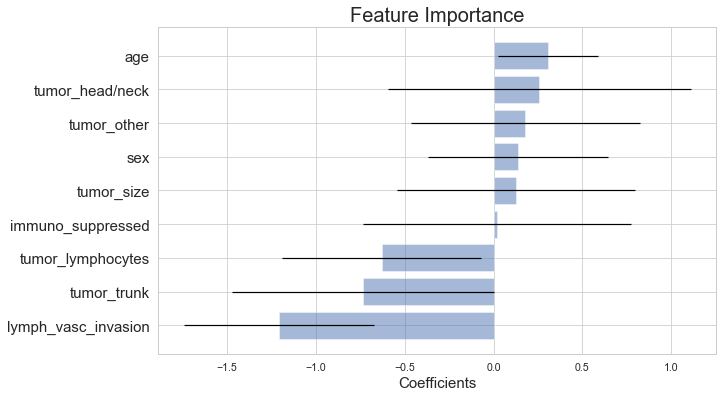

In [736]:
# make summary table 
stats_summary = pd.DataFrame()
stats_summary['features'] = preproc_feature_order.variable
stats_summary['mean'] = stats.mean(axis = 1)
stats_summary['upper'] = upper_CI_q
stats_summary['lower'] = lower_CI_q

# redo feature importance, with CI 
coefs_ordered = stats_summary.sort_values(by = 'mean', ascending = False, ignore_index = True)
n_features = coefs_ordered.shape[0]
error = coefs_ordered['upper'] - coefs_ordered['mean']

filename = os.path.join(figure_path, "feature_importance_trainval_bootstrap_CI.png")
plt.figure(figsize = (10, 8))
fig, ax = plt.subplots(1,1, figsize = (10,6))
ax.barh(coefs_ordered['features'], coefs_ordered['mean'], xerr = error,
        align = 'center', alpha = 0.5, ecolor = "black")
ax.set_yticklabels(coefs_ordered['features'], size = 15)
ax.invert_yaxis()
ax.set_xlabel("Coefficients", size = 15)
ax.set_title("Feature Importance", size = 20)
plt.savefig(filename, bbox_inches = 'tight')
plt.show()
